# Advection in Spherical coordinates
In this notebook, we will solve the advection equation in spherical coordinates using the finite volume method. The notebook serves as the first attempt at testing the implementation of advection and diffusion terms in `PyFVTool`, and might be removed in the future.

In [22]:
import sys
import os

current_dir = os.getcwd()
print(current_dir)
target_dir = os.path.abspath(os.path.join(current_dir, "..", "src"))
sys.path.append(target_dir)
# # Use a raw string for the path
# sys.path.append(r'C:\projects\git\PyFVTool\src')

# # Print sys.path to verify the path is added
# print(sys.path)

c:\projects\git\PyFVTool\examples-notebooks


In [23]:
from pyfvtool.mesh import SphericalGrid3D
import numpy as np

In [24]:
X = np.array([0.01, 0.1, 0.3, 0.5, 0.55, 1.0])
Y = np.array([0.0, 0.1, 1.0, 1.5, 2.9, 3.0, np.pi, 2 * np.pi])
Z = np.array([0.0, 0.01, 0.1, 0.5, 0.7, 0.95, 1.0, 1.25, 1.39, 2.0])
m_non = SphericalGrid3D(X, Y, Z)

In [25]:
import pyfvtool as pf

# Solving a 1D diffusion equation with a fixed concentration
# at the left boundary and a closed boundary on the right side


# Calculation parameters
def diffusion_spherical(mesh, t_simulation=7200.0, dt=60.0):
    c_left = 1.0  # left boundary concentration
    c_init = 0.0  # initial concentration
    D_val = 1e-5  # diffusion coefficient (gas phase)

    # Create a cell variable with initial concentration
    # By default, 'no flux' boundary conditions are applied
    c = pf.CellVariable(mesh, c_init)

    # Switch the right boundary to Dirichlet: fixed concentration
    c.BCs.right.a[:] = 0.0
    c.BCs.right.b[:] = 1.0
    c.BCs.right.c[:] = c_left
    if type(mesh) == SphericalGrid3D:
        # make top and bottom boundaries periodic
        c.BCs.top.periodic = True
        c.BCs.bottom.periodic = True

    c.apply_BCs()

    # Assign diffusivity to cells
    D_cell = pf.CellVariable(mesh, D_val)
    D_face = pf.geometricMean(
        D_cell
    )  # average value of diffusivity at the interfaces between cells

    # Time loop
    t = 0
    while t < t_simulation:
        # Compose discretized terms for matrix equation
        eqnterms = [pf.transientTerm(c, dt, 1.0), -pf.diffusionTerm(D_face)]

        # Solve PDE
        pf.solvePDE(c, eqnterms)
        t += dt
    return c

In [26]:
import pyfvtool as pf

# reload the module to get the updated version
import importlib

importlib.reload(pf)

import numpy as np
import matplotlib.pyplot as plt

# Solving a 3D diffusion equation with a fixed concentration
# at the left boundary and a closed boundary on the right side


# Calculation parameters
Nx = 20  # number of finite volume cells
Ntheta = 6  # number of cells in the theta direction; avoid theta=0 and theta=pi
Nphi = 5  # number of cells in the phi direction
Lx = 1.0  # [m] length of the domain

# Define mesh
mesh1 = pf.SphericalGrid1D(Nx, Lx)
c1 = diffusion_spherical(mesh1)
mesh3 = pf.SphericalGrid3D(Nx, Ntheta, Nphi, Lx, 2 * np.pi, 2 * np.pi)
c3 = diffusion_spherical(mesh3)
mesh1_rad = pf.CylindricalGrid1D(Nx, Lx)
c1_rad = diffusion_spherical(mesh1_rad)
mesh3_cyl = pf.CylindricalGrid3D(Nx, Ntheta, Nphi, Lx, 2 * np.pi, 2 * np.pi)
c3_cyl = diffusion_spherical(mesh3_cyl)

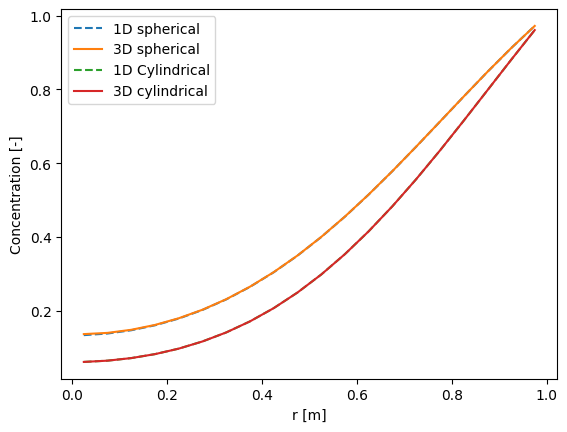

In [27]:
plt.plot(mesh1.cellcenters.r, c1.value, "--", label="1D spherical")
plt.plot(mesh3.cellcenters.r, c3.value[:, 0, 0], label="3D spherical")
plt.plot(mesh1_rad.cellcenters.r, c1_rad.value, "--", label="1D Cylindrical")
plt.plot(mesh3_cyl.cellcenters.r, c3_cyl.value[:, 0, 0], label="3D cylindrical")
plt.xlabel("r [m]")
plt.ylabel("Concentration [-]")
plt.legend()